## Downloading the files

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip


# Initializing Spark Session & reading the data

In [73]:
import pandas as pd
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName('recommendation_system').getOrCreate()

# Load ratings data
ratings_df = spark.read.csv('ml-latest-small/ratings.csv', header=True, inferSchema=True)
movies_df = spark.read.csv('ml-latest-small/movies.csv', header=True, inferSchema=True)
# Show a sample of the data
ratings_df.show(5)
movies_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



# EDA & Data Visualization

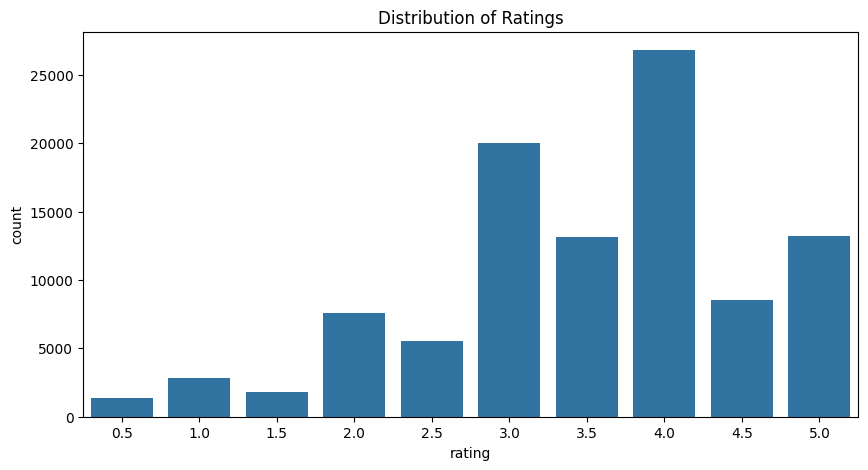

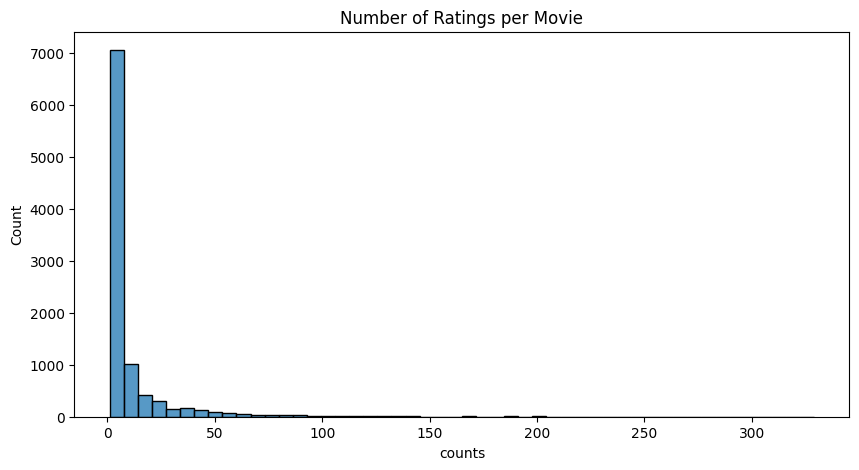

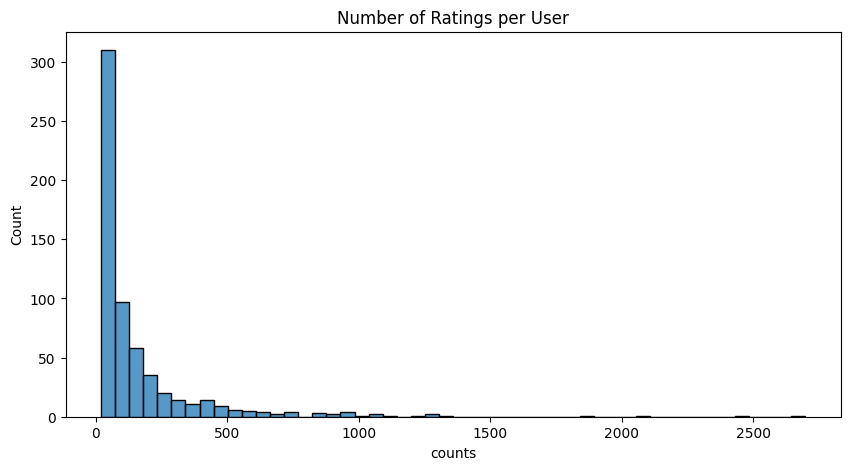

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame for EDA
ratings_pd = ratings_df.toPandas()
movies_pd = movies_df.toPandas()

# Distribution of ratings
plt.figure(figsize=(10, 5))
sns.countplot(x='rating', data=ratings_pd)
plt.title('Distribution of Ratings')
plt.show()

# Number of ratings per movie
movie_ratings = ratings_pd.groupby('movieId').size().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.histplot(movie_ratings['counts'], bins=50, kde=False)
plt.title('Number of Ratings per Movie')
plt.show()

# Number of ratings per user
user_ratings = ratings_pd.groupby('userId').size().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.histplot(user_ratings['counts'], bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.show()


**Top 10 Movies**

In [75]:
# Merge ratings and movies data
ratings_movies_pd = pd.merge(ratings_pd, movies_pd, on='movieId')

# Calculate average rating and number of ratings per movie
movie_stats = ratings_movies_pd.groupby('title').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['mean_rating', 'num_ratings']
movie_stats = movie_stats.reset_index()

# Filter movies with at least 100 ratings
popular_movies = movie_stats[movie_stats['num_ratings'] >= 100]

# Top 10 movies by average rating
top_10_movies = popular_movies.sort_values('mean_rating', ascending=False).head(10)
print(top_10_movies)


                                 title  mean_rating  num_ratings
7593  Shawshank Redemption, The (1994)     4.429022          317
3499             Godfather, The (1972)     4.289062          192
3011                 Fight Club (1999)     4.272936          218
3500    Godfather: Part II, The (1974)     4.259690          129
2334              Departed, The (2006)     4.252336          107
3564                 Goodfellas (1990)     4.250000          126
1593                 Casablanca (1942)     4.240000          100
2163           Dark Knight, The (2008)     4.238255          149
9119        Usual Suspects, The (1995)     4.237745          204
6808        Princess Bride, The (1987)     4.232394          142


# Feature Engineering

In [76]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Indexing and encoding user and movie IDs
user_indexer = StringIndexer(inputCol='userId', outputCol='user_index')
movie_indexer = StringIndexer(inputCol='movieId', outputCol='movie_index')
pipeline = Pipeline(stages=[user_indexer, movie_indexer])
ratings_df = pipeline.fit(ratings_df).transform(ratings_df)

# Show the transformed data
ratings_df.show(5)


+------+-------+------+---------+----------+-----------+
|userId|movieId|rating|timestamp|user_index|movie_index|
+------+-------+------+---------+----------+-----------+
|     1|      1|   4.0|964982703|     111.0|       11.0|
|     1|      3|   4.0|964981247|     111.0|      422.0|
|     1|      6|   4.0|964982224|     111.0|      129.0|
|     1|     47|   5.0|964983815|     111.0|       15.0|
|     1|     50|   5.0|964982931|     111.0|       14.0|
+------+-------+------+---------+----------+-----------+
only showing top 5 rows



# ALS MODEL

In [77]:
from pyspark.ml.recommendation import ALS

# Train a matrix factorization model using ALS
als = ALS(userCol='user_index', itemCol='movie_index', ratingCol='rating', coldStartStrategy='drop', nonnegative=True)
model = als.fit(ratings_df)

# Evaluate the model
predictions = model.transform(ratings_df)
predictions.show(5)


+------+-------+------+----------+----------+-----------+----------+
|userId|movieId|rating| timestamp|user_index|movie_index|prediction|
+------+-------+------+----------+----------+-----------+----------+
|   185|   3949|   5.0|1044311310|     392.0|      148.0| 4.0346675|
|   140|   1017|   4.0|1021899101|      31.0|     2122.0| 3.6936102|
|   140|   3906|   3.0|1005326428|      31.0|     5518.0| 2.8545215|
|   140|   4339|   4.0| 993208220|      31.0|     3918.0|  3.791033|
|   159|   3949|   0.5|1508641203|     251.0|      148.0|  2.064802|
+------+-------+------+----------+----------+-----------+----------+
only showing top 5 rows



# XG Boost

In [79]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare data for XGBoost
ratings_pd = ratings_df.toPandas()
X = ratings_pd[['user_index', 'movie_index']]
y = ratings_pd['rating']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predict ratings
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f'Root Mean Squared Error (RMSE) of XGBoost model: {rmse_xgb:.2f}')


Root Mean Squared Error (RMSE) of XGBoost model: 0.95


# Neural Collaborative Filtering

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense

# Hyperparameters
num_users = ratings_df.select('user_index').distinct().count()
num_movies = ratings_df.select('movie_index').distinct().count()
embedding_size = 50

# User and movie input layers
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# Embedding layers
user_embedding = Embedding(num_users, embedding_size)(user_input)
movie_embedding = Embedding(num_movies, embedding_size)(movie_input)

# Dot product of user and movie embeddings
dot_product = Dot(axes=2)([user_embedding, movie_embedding])
dot_product = Flatten()(dot_product)

# Output layer
output = Dense(1, activation='sigmoid')(dot_product)

# Model definition
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare the data for training
import numpy as np

user_indices = np.array(ratings_df.select('user_index').collect()).reshape(-1)
movie_indices = np.array(ratings_df.select('movie_index').collect()).reshape(-1)
ratings = np.array(ratings_df.select('rating').collect()).reshape(-1)

# Training the model
history = model.fit([user_indices, movie_indices], ratings, epochs=5, batch_size=128, validation_split=0.2)


Epoch 1/5
631/631 [==============================] - 12s 17ms/step - loss: -2.2406 - accuracy: 0.0270 - val_loss: -1.1397 - val_accuracy: 0.0308
Epoch 2/5
631/631 [==============================] - 9s 15ms/step - loss: -70.1103 - accuracy: 0.0271 - val_loss: -3.4639 - val_accuracy: 0.0308
Epoch 3/5
631/631 [==============================] - 6s 9ms/step - loss: -320.0678 - accuracy: 0.0271 - val_loss: -6.7561 - val_accuracy: 0.0305
Epoch 4/5
631/631 [==============================] - 8s 13ms/step - loss: -809.2396 - accuracy: 0.0271 - val_loss: -11.1616 - val_accuracy: 0.0304
Epoch 5/5
631/631 [==============================] - 10s 16ms/step - loss: -1570.3555 - accuracy: 0.0271 - val_loss: -16.8855 - val_accuracy: 0.0302


In [78]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the ALS model
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE) of ALS model: {rmse:.2f}')


Root Mean Squared Error (RMSE) of ALS model: 0.61


In [69]:
from sklearn.metrics import mean_squared_error

# Make predictions
predictions = model.predict([user_indices, movie_indices])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(ratings, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


3152/3152 [==============================] - 9s 3ms/step
Root Mean Squared Error (RMSE): 2.73


In [84]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10]) \
    .addGrid(als.regParam, [0.01]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# Define cross-validator
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Train cross-validator model
cv_model = crossval.fit(ratings_df)

# Best model
best_als_model = cv_model.bestModel


In [ ]:
from sklearn.model_selection import KFold

# Prepare data for cross-validation
X = ratings_pd[['user_index', 'movie_index']]
y = ratings_pd['rating']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for XGBoost
xgb_rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
    xgb_rmse_scores.append(rmse)

print(f'XGBoost Cross-Validation RMSE Scores: {xgb_rmse_scores}')
print(f'Mean RMSE: {np.mean(xgb_rmse_scores)}')


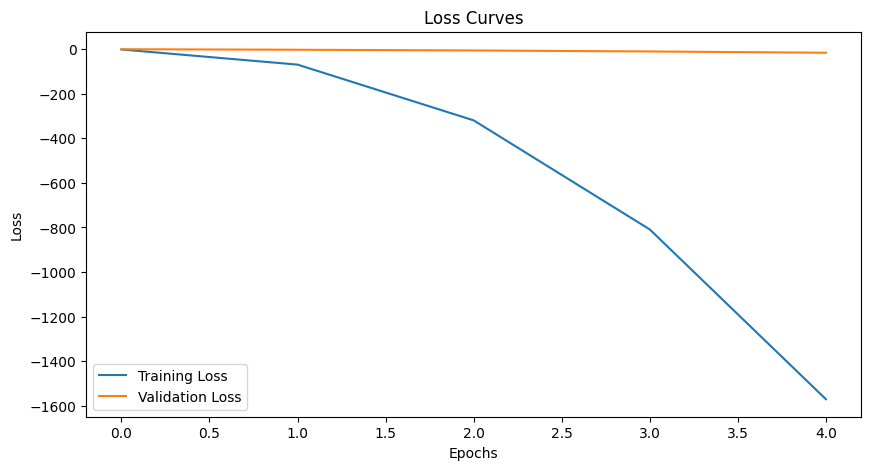

In [85]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [80]:
import plotly.express as px

# Interactive distribution of ratings
fig = px.histogram(ratings_pd, x='rating', title='Distribution of Ratings')
fig.show()

# Interactive top-rated movies
fig = px.bar(top_10_movies, x='title', y='mean_rating', title='Top 10 Movies by Average Rating')
fig.show()

# Interactive number of ratings per movie
fig = px.histogram(movie_ratings, x='counts', title='Number of Ratings per Movie')
fig.show()
